In [ ]:
!pip install wandb  -qU

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.29.34 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


True

## 1. Set Up

In [ ]:
!pip install -q -U einops datasets matplotlib tqdm torchvision torchmetrics

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [ ]:
import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import sklearn.metrics
import torchmetrics

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.autograd import Variable, grad
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torch.optim import Adam

from skimage.metrics import structural_similarity as ssim
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

## 2. Load Model

In [ ]:
import DDPM

In [ ]:
from DDPM import GaussianDiffusion, linear_beta_schedule, cosine_beta_schedule
from UNet import Unet

In [ ]:
batch_size = 16
channels = 3
image_size = 128
timesteps = 1000
mode = 'c'

In [ ]:
model = Unet(
    dim=64,
    channels = channels+1,
    out_dim = channels,
    dim_mults=(1, 2, 4, 8,)

)
model.load_state_dict(torch.load('models/128_RGB/model_c_128_rgb_chkpt_32.pth'))
#model.load_state_dict(torch.load('models/128_RGB/model_c_128_rgb_chkpt_32.pth'))

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

betas = linear_beta_schedule(timesteps)

optimizer = Adam(model.parameters(), lr= 2e-4)

diffusion = GaussianDiffusion(
                model,
                mode = mode,
                image_size = image_size,
                channels = channels,
                timesteps = timesteps,
                loss_type = 'l1',
                betas = betas,
                device = device
                )

In [ ]:
def get_layer_names(model):
    layer_names = []
    for name, layer in model.named_modules():
        for layer_definition in [nn.Conv2d]:
            if isinstance(layer, layer_definition) or issubclass(layer.__class__, layer_definition):
                if name not in layer_names:
                    layer_names.append(name)

    return layer_names

## 3. Dataset

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Dataset, DataLoader
from CelebA import CelebADataset

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop((178,178)),
            transforms.Resize((image_size,image_size))
])

In [ ]:
labels = ['Bangs','Male','Smiling','Wearing_Lipstick']

In [ ]:
dataset = CelebADataset("list_attr_celeba.txt","celeb_align/img_align_celeba/",labels=labels,transform=transform)

In [ ]:
dataset.__len__()

74999

In [ ]:
train_size = int(0.8* len(dataset))
test_size =  len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Analyze train data

In [ ]:
#read and transform attribution dataset
a_f = pd.read_csv("list_attr_celeba.txt",sep='\s+')
a_f = a_f.replace(-1,0)
a_f = a_f.loc[:,a_f.columns.intersection(labels)]

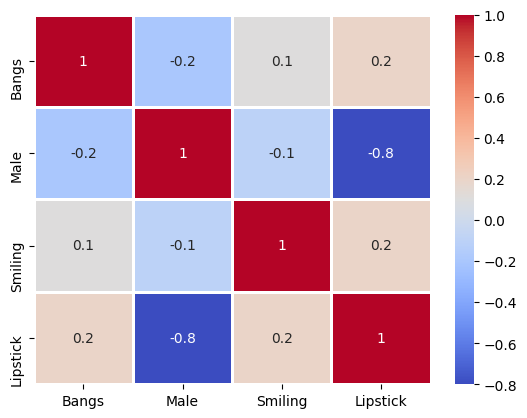

In [ ]:
a_f = a_f.rename(columns={"Wearing_Lipstick": "Lipstick"})
matrix = a_f.corr().round(1)
res = sns.heatmap(matrix,
                  cmap="coolwarm",
                  linewidths = 2,
                  linecolor = "white",
                  annot=True)

plt.show()

In [ ]:
a_f = pd.read_csv("list_attr_celeba.txt",sep='\s+')
a_f = a_f.replace(-1,0)
s = a_f.sum()
a_f = a_f[s.sort_values(ascending=False).index[:20]]

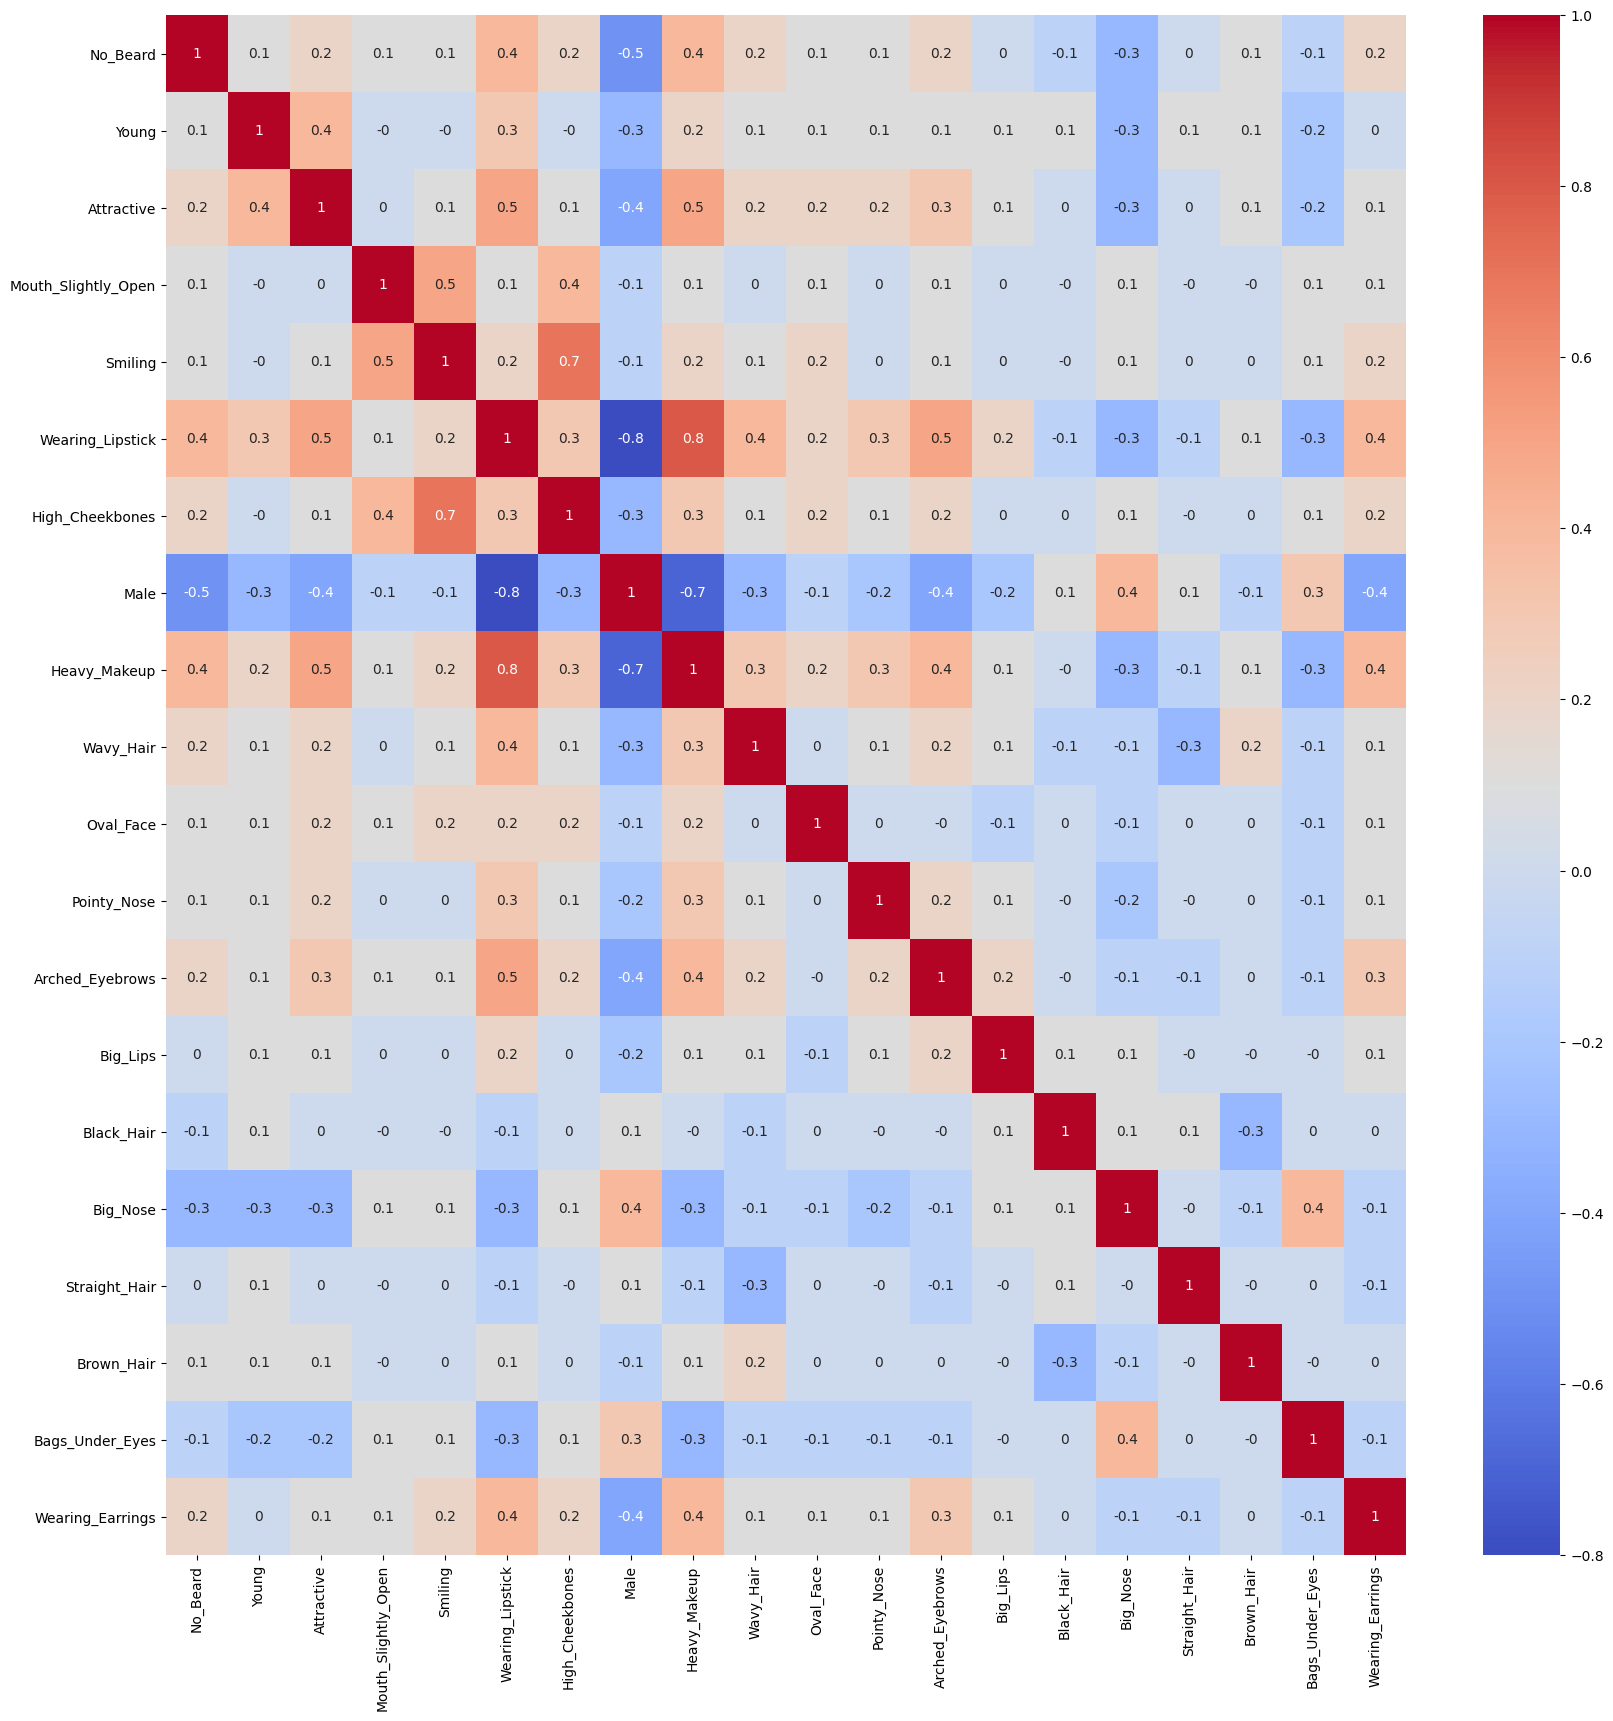

In [ ]:
matrix = a_f.corr().round(1)
plt.figure(figsize=(20,20))
res = sns.heatmap(matrix,
                  cmap="coolwarm",
                  annot=True)

## 4. Train Model

In [ ]:
analysis_settings = {
    "resolution": 1001,
    "layers": [],
    "track_mode": 0,
    "gradient_mask": None,
}

In [ ]:
from logging import logProcesses
from torchvision.utils import save_image


checkpoints = [35,40]
for epoch in np.arange(31,42):
    print("Epoch:", epoch)
    if epoch in checkpoints:
            torch.save(model.state_dict(), 'models/128_RGB_NEW/model_c_128_rgb_chkpt_'+str(epoch)+'.pth')
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        batch_size = batch["image"].shape[0]
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        x = batch["image"].to(device)
        if mode == 'c':

            y = batch["label"].to(device)
            assert torch.is_tensor(y)
            if len(y.shape) == 1: # Labels 1D
                y = diffusion.label_reshaping(y,batch_size,image_size,image_size,device)

            loss, psnr, ssim = diffusion.p_losses( x, t, loss_type="l1", y=y)

        else:
            loss, psnr, ssim = diffusion.p_losses( x, t, loss_type="l1")

        if step % 100 == 0:
            if step % 1000 == 0:
                val_cond = torch.tensor([2]).to(device)
                samples, grad_vol, acts, grads = diffusion.sample(batch_size=1, condition = val_cond, analysis=analysis_settings)
                images = wandb.Image(samples[999][0,:,:,:].T, caption="Diffusion sample")
                metrics = {"train/train_loss": loss.item(),
                     "train/train_psnr": psnr,
                     "train/train_ssim": ssim,
                     "examples": images}
            else:
                metrics = {"train/train_loss": loss.item(),
                     "train/train_psnr": psnr,
                     "train/train_ssim": ssim}

            wandb.log(metrics)


        loss.backward()
        optimizer.step()
    #after each epoch sample for validation to verify progress



In [ ]:
torch.save(model.state_dict(), 'models/128_RGB_NEW/model_c_128_rgb_chkpt_41.pth')

In [ ]:
wandb.finish()

In [ ]:
#save model
torch.save(model.state_dict(), 'models/model_c_128_rgb_1st.pth')

## 5. Sample

In [ ]:
#label
y = torch.tensor([3]).to(device)

#gradient_mask
g_mask = torch.zeros((image_size,image_size)).to(device)
g_mask[50:60,35:45] = 1

#layers
#layers = ["downs.0.0.res_conv","downs.1.0.res_conv","downs.2.0.res_conv","ups.0.0.res_conv","ups.1.0.res_conv"]
layers = ["downs.1.2.fn","downs.2.2.fn","downs.3.2.fn","mid_attn.fn","ups.0.2.fn","ups.1.2.fn"]
#attention_layers = ["downs.0.2.fn.fn","downs.1.2.fn.fn","downs.2.2.fn.fn","ups.0.2.fn.fn","mid_attn.fn.fn"]

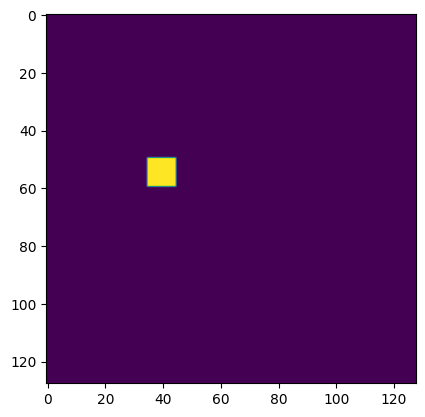

In [ ]:
g_mask = np.zeros((image_size,image_size))
g_mask[50:60,35:45] = 1
plt.imshow(g_mask)

In [ ]:
y1 = torch.tensor([3]).to(device)
random_seed = 432
analysis_settings = {
        "sample_steps": sample_steps,
        "layers": layers,
        "track_mode": 0,
        "mask": None,
        "s_y": torch.tensor([3]).to(device),
        "s_t": None
    }


In [ ]:
samples, grad_vol, acts, grads = diffusion.sample(batch_size=1,random_seed=321, condition = y, analysis=analysis_settings)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


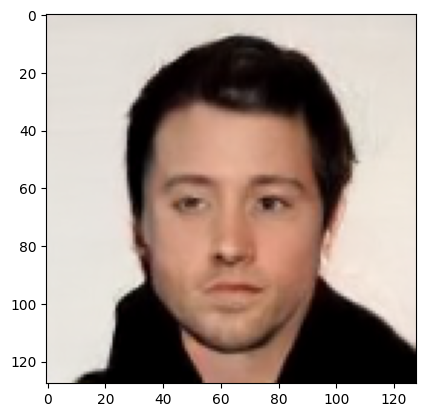

In [ ]:
plt.imshow(original_sample[999][0,:,:,:].swapaxes(0,1).swapaxes(1,2))